In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import albumentations as A
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from PIL import Image
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib import pyplot as plt
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
datapath = r'C:\Users\solunkedi\OneDrive - VMware, Inc\Dinesh Solunke\Greate Learning Project\Capstone Project\repo'
DIR_INPUT = datapath + '/input'
DIR_TEST = f"{DIR_INPUT}/samples"
test_images = os.listdir(DIR_TEST)
print(f"Test instances: {len(test_images)}")


Test instances: 3000


In [13]:
# load COCO pretrained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # 1 class is pneumonia and the other is background
# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# fine-tune head
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

os.makedirs('../test_predictions', exist_ok=True)


device =  torch.device('cpu')
model.load_state_dict(torch.load(datapath + '/faster_rcnn_resnet_final_project/fasterrcnn_resnet50_fpn.pth', map_location=torch.device(device)))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [14]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

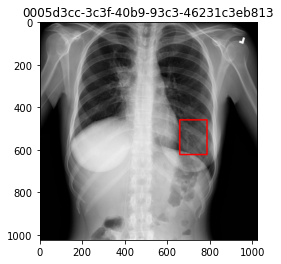

[{'patientId': '0005d3cc-3c3f-40b9-93c3-46231c3eb813', 'PredictionString': '0.5504 656 459 128 163'}]


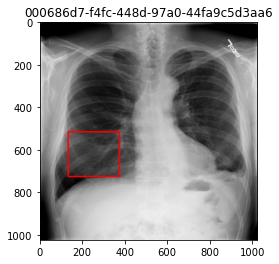

[{'patientId': '000686d7-f4fc-448d-97a0-44fa9c5d3aa6', 'PredictionString': '0.6328 132 515 241 210'}]


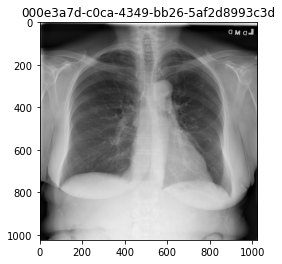

[{'patientId': '000e3a7d-c0ca-4349-bb26-5af2d8993c3d', 'PredictionString': ''}]


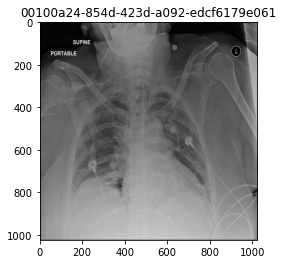

[{'patientId': '00100a24-854d-423d-a092-edcf6179e061', 'PredictionString': ''}]


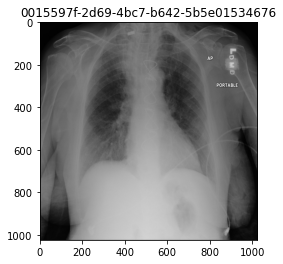

[{'patientId': '0015597f-2d69-4bc7-b642-5b5e01534676', 'PredictionString': ''}]


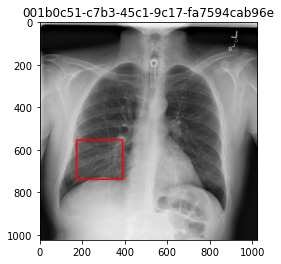

[{'patientId': '001b0c51-c7b3-45c1-9c17-fa7594cab96e', 'PredictionString': '0.5282 171 554 216 184'}]


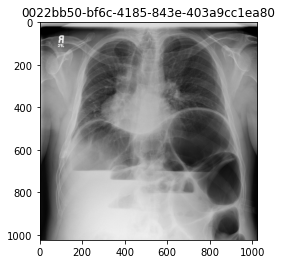

[{'patientId': '0022bb50-bf6c-4185-843e-403a9cc1ea80', 'PredictionString': ''}]


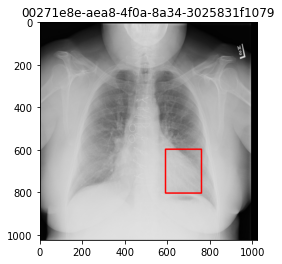

[{'patientId': '00271e8e-aea8-4f0a-8a34-3025831f1079', 'PredictionString': '0.8742 589 597 169 206'}]


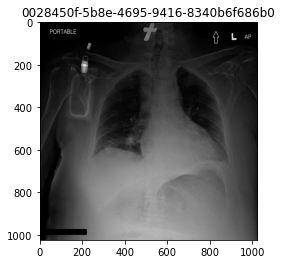

[{'patientId': '0028450f-5b8e-4695-9416-8340b6f686b0', 'PredictionString': ''}]


In [31]:
for i in range(1,10):
    
    orig_image = cv2.imread(f"{DIR_TEST}/{test_images[i]}", cv2.IMREAD_COLOR)
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
#     plt.imshow(image)
#     plt.title(test_images[i].split('.')[0])
#     plt.show()

    image = image/255.0
    image = np.transpose(image, (2, 0, 1)).astype(np.float)
    image = torch.tensor(image, dtype=torch.float).cpu()
    image = torch.unsqueeze(image, 0)

    detection_threshold = 0.5
    img_num = 0
    results = []
    model.eval()

    cpu_device = torch.device("cpu")
    model.eval()
    outputs = model(image)

    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

    if len(outputs[0]['boxes']) != 0:
        for counter in range(len(outputs[0]['boxes'])):
            boxes = outputs[0]['boxes'].data.cpu().numpy()
            scores = outputs[0]['scores'].data.cpu().numpy()
            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            draw_boxes = boxes.copy()
            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        for box in draw_boxes:
            cv2.rectangle(orig_image,
                          (int(box[0]), int(box[1])),
                          (int(box[2]), int(box[3])),
                          (0, 0, 255), 5)

        plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
        plt.title(test_images[i].split('.')[0])
        plt.show()
#         plt.axis('on')
        
        result = {
                'patientId': test_images[i].split('.')[0],
                'PredictionString': format_prediction_string(boxes, scores)
            }
        results.append(result)
        print(results)

In [15]:
detection_threshold = 0.9
img_num = 0
results = []
model.eval()
with torch.no_grad():
    for i, image in tqdm(enumerate(test_images), total=len(test_images)):

        orig_image = cv2.imread(f"{DIR_TEST}/{test_images[i]}", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
        image = image/255.0
        image = np.transpose(image, (2, 0, 1)).astype(np.float)
        image = torch.tensor(image, dtype=torch.float).cpu()
        image = torch.unsqueeze(image, 0)

        cpu_device = torch.device("cpu")

        outputs = model(image)
        
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        if len(outputs[0]['boxes']) != 0:
            for counter in range(len(outputs[0]['boxes'])):
                boxes = outputs[0]['boxes'].data.cpu().numpy()
                scores = outputs[0]['scores'].data.cpu().numpy()
                boxes = boxes[scores >= detection_threshold].astype(np.int32)
                draw_boxes = boxes.copy()
                boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
            
            for box in draw_boxes:
                cv2.rectangle(orig_image,
                            (int(box[0]), int(box[1])),
                            (int(box[2]), int(box[3])),
                            (0, 0, 255), 3)
        
            plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
            plt.axis('on')
            testpath = r'C:\Users\solunkedi\OneDrive - VMware, Inc\Dinesh Solunke\Greate Learning Project\Capstone Project\repo'
            plt.savefig(testpath + f"/test_predictions/{test_images[i]}")

#             plt.savefig(f"/content/drive/MyDrive/Capstone_CV/P_Detection_FRCNN/test_predictions/{test_images[i]}")
            plt.close()
                
            result = {
                'patientId': test_images[i].split('.')[0],
                'PredictionString': format_prediction_string(boxes, scores)
            }
            results.append(result)
        else:
            result = {
                'patientId': test_images[i].split('.')[0],
                'PredictionString': None
            }
            results.append(result)

 16%|███████████▉                                                               | 477/3000 [1:10:04<6:10:40,  8.81s/it]


KeyboardInterrupt: 

In [ ]:
sub_df = pd.DataFrame(results, columns=['patientId', 'PredictionString'])
sub_df.head(100)

testpath = r'C:\Users\solunkedi\OneDrive - VMware, Inc\Dinesh Solunke\Greate Learning Project\Capstone Project\repo'
sub_df.to_csv(testpath + '/test_predictions/Predictions.csv', index=False)